# Gait Data Pipeline

Compact notebook for:
- walking-only dataset cleaning,
- synthetic data expansion,
- post-synthetic EDA and feature engineering.

Synthetic training data path used in this notebook:
- `data/synthetic_walking_data`


## Imports and Path Setup

Notebook is rerun-safe by default:
- reuses existing cleaned and synthetic datasets,
- does not create extra `batch_*` folders on rerun,
- only rebuilds when `FORCE_REBUILD_CLEANED` or `FORCE_REBUILD_SYNTH` is set to `True`.


In [1]:
import json
import hashlib
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'data').exists() and (PROJECT_ROOT.parent / 'data').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATASET_PATH = PROJECT_ROOT / 'data/datasets/UCI HAR Dataset/UCI HAR Dataset'
CLEANED_PATH = PROJECT_ROOT / 'data/cleaned_walking_data'
SYNTH_PATH = PROJECT_ROOT / 'data/synthetic_walking_data'
RESULTS_PATH = PROJECT_ROOT / 'results'
POST_RESULTS_PATH = RESULTS_PATH / 'post_synthetic_analysis'

for p in [CLEANED_PATH, SYNTH_PATH, RESULTS_PATH, POST_RESULTS_PATH]:
    p.mkdir(parents=True, exist_ok=True)

# Rerun-safe controls
FORCE_REBUILD_CLEANED = False
FORCE_REBUILD_SYNTH = False

DEFAULT_SAMPLES_PER_SUBJECT = 10000
DEFAULT_BATCH_SIZE = 50000


def has_batches(path: Path) -> bool:
    return any(p.is_dir() for p in path.glob('batch_*'))


def clear_batch_dirs(path: Path):
    for p in sorted(path.glob('batch_*')):
        if p.is_dir():
            shutil.rmtree(p)


print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATASET_PATH exists:', DATASET_PATH.exists())
print('FORCE_REBUILD_CLEANED:', FORCE_REBUILD_CLEANED)
print('FORCE_REBUILD_SYNTH:', FORCE_REBUILD_SYNTH)


PROJECT_ROOT: /home/anshu/code_space/ai-employee-auth
DATASET_PATH exists: True
FORCE_REBUILD_CLEANED: False
FORCE_REBUILD_SYNTH: False


## Cleaning Helpers


In [2]:
def load_split(dataset_path: Path, split: str):
    base = dataset_path / split
    y = np.loadtxt(base / f'y_{split}.txt', dtype=int)
    subjects = np.loadtxt(base / f'subject_{split}.txt', dtype=int)
    X = np.loadtxt(base / f'X_{split}.txt')
    inertial = base / 'Inertial Signals'
    body_acc_x = np.loadtxt(inertial / f'body_acc_x_{split}.txt')
    body_acc_y = np.loadtxt(inertial / f'body_acc_y_{split}.txt')
    body_acc_z = np.loadtxt(inertial / f'body_acc_z_{split}.txt')
    return {
        'subjects': subjects,
        'labels': y,
        'features': X,
        'body_acc_x': body_acc_x,
        'body_acc_y': body_acc_y,
        'body_acc_z': body_acc_z,
    }


def filter_walking(data):
    mask = data['labels'] == 1
    return {k: v[mask] for k, v in data.items()}


def validate_cleaned(data, split_name='split'):
    assert np.all(data['labels'] == 1), f'{split_name}: non-walking labels found'
    n = len(data['labels'])
    for k, v in data.items():
        assert len(v) == n, f'{split_name}: shape mismatch in {k}'
    for k in ['features', 'body_acc_x', 'body_acc_y', 'body_acc_z']:
        assert not np.isnan(data[k]).any(), f'{split_name}: NaN in {k}'
        assert not np.isinf(data[k]).any(), f'{split_name}: Inf in {k}'


def save_cleaned_split(data, out_path: Path):
    out_path.mkdir(parents=True, exist_ok=True)
    for k, v in data.items():
        np.save(out_path / f'{k}.npy', v)
    metadata = {
        'n_samples': int(len(data['subjects'])),
        'n_subjects': int(len(np.unique(data['subjects']))),
        'subjects': sorted(np.unique(data['subjects']).tolist()),
        'sampling_rate': 50,
        'window_size': 128,
        'activity': 'WALKING',
    }
    with open(out_path / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)


def load_cleaned_split(in_path: Path):
    return {
        'subjects': np.load(in_path / 'subjects.npy'),
        'labels': np.load(in_path / 'labels.npy'),
        'features': np.load(in_path / 'features.npy'),
        'body_acc_x': np.load(in_path / 'body_acc_x.npy'),
        'body_acc_y': np.load(in_path / 'body_acc_y.npy'),
        'body_acc_z': np.load(in_path / 'body_acc_z.npy'),
    }


## Run Walking-Only Cleaning


In [3]:
activity_labels = pd.read_csv(
    DATASET_PATH / 'activity_labels.txt',
    sep=' ',
    header=None,
    names=['label_id', 'activity_name']
)
activity_labels


,label_id,activity_name
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [4]:
clean_train_ready = (CLEANED_PATH / 'train' / 'subjects.npy').exists()
clean_test_ready = (CLEANED_PATH / 'test' / 'subjects.npy').exists()

if clean_train_ready and clean_test_ready and not FORCE_REBUILD_CLEANED:
    print('Using existing cleaned dataset from disk (skip rebuild).')
    train_walking = load_cleaned_split(CLEANED_PATH / 'train')
    test_walking = load_cleaned_split(CLEANED_PATH / 'test')
else:
    print('Building cleaned walking-only dataset...')
    train_raw = load_split(DATASET_PATH, 'train')
    test_raw = load_split(DATASET_PATH, 'test')

    train_walking = filter_walking(train_raw)
    test_walking = filter_walking(test_raw)

    validate_cleaned(train_walking, 'train')
    validate_cleaned(test_walking, 'test')

    save_cleaned_split(train_walking, CLEANED_PATH / 'train')
    save_cleaned_split(test_walking, CLEANED_PATH / 'test')

summary_df = pd.DataFrame({
    'split': ['train', 'test', 'total'],
    'walking_samples': [
        len(train_walking['subjects']),
        len(test_walking['subjects']),
        len(train_walking['subjects']) + len(test_walking['subjects']),
    ],
    'unique_subjects': [
        len(np.unique(train_walking['subjects'])),
        len(np.unique(test_walking['subjects'])),
        len(np.unique(np.concatenate([train_walking['subjects'], test_walking['subjects']])))
    ]
})
summary_df.to_csv(CLEANED_PATH / 'cleaning_summary.csv', index=False)
summary_df


Using existing cleaned dataset from disk (skip rebuild).


,split,walking_samples,unique_subjects
0,train,1365,30
1,test,357,30
2,total,1722,30


## Quick Cleaning EDA


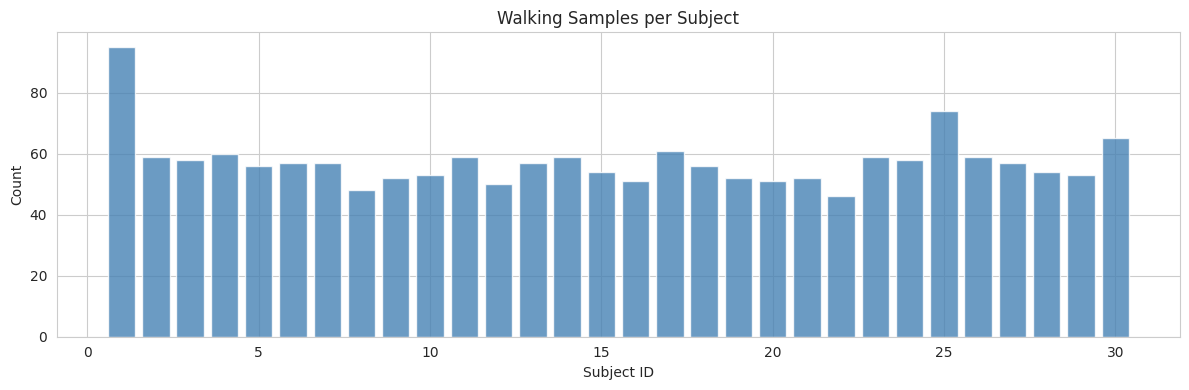

In [5]:
all_subjects = np.concatenate([train_walking['subjects'], test_walking['subjects']])
subject_counts = pd.Series(all_subjects).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(subject_counts.index, subject_counts.values, color='steelblue', alpha=0.8)
ax.set_title('Walking Samples per Subject')
ax.set_xlabel('Subject ID')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


## Display First 5 Rows of Dataset


In [6]:
# Display first 5 rows of training data
print("\n=== First 5 Samples from Training Set ===")
print(f"\nSubjects: {train_walking['subjects'][:5]}")
print(f"Labels: {train_walking['labels'][:5]}")
print(f"\nBody Acceleration X (first sample, first 10 values):")
print(train_walking['body_acc_x'][0][:10])
print(f"\nBody Acceleration Y (first sample, first 10 values):")
print(train_walking['body_acc_y'][0][:10])
print(f"\nBody Acceleration Z (first sample, first 10 values):")
print(train_walking['body_acc_z'][0][:10])
print(f"\nFeatures shape: {train_walking['features'].shape}")
print(f"Features (first sample, first 10 values):")
print(train_walking['features'][0][:10])

# Create a DataFrame for better visualization
df_sample = pd.DataFrame({
    'Subject': train_walking['subjects'][:5],
    'Label': train_walking['labels'][:5],
    'Body_Acc_X_Mean': [train_walking['body_acc_x'][i].mean() for i in range(5)],
    'Body_Acc_Y_Mean': [train_walking['body_acc_y'][i].mean() for i in range(5)],
    'Body_Acc_Z_Mean': [train_walking['body_acc_z'][i].mean() for i in range(5)],
})
print("\n=== Summary of First 5 Samples ===")
print(df_sample)



=== First 5 Samples from Training Set ===

Subjects: [ 1 29  7 23 16]
Labels: [1 1 1 1 1]

Body Acceleration X (first sample, first 10 values):
[ 0.3767984   0.3820639   0.119208   -0.2899142  -0.3154718  -0.08307199
  0.0232823   0.00953036 -0.05062241 -0.06971416]

Body Acceleration Y (first sample, first 10 values):
[-0.07615856 -0.09193956  0.04778273  0.1504967   0.1771746   0.04559202
 -0.1562965  -0.1657575  -0.1285168  -0.1101273 ]

Body Acceleration Z (first sample, first 10 values):
[-0.01594575 -0.1020025  -0.05738191 -0.06630582 -0.08802383 -0.08833906
 -0.1042951  -0.07855552 -0.05962858 -0.06741271]

Features shape: (1365, 561)
Features (first sample, first 10 values):
[ 0.28656754  0.02061928 -0.0925359  -0.35839925  0.18479877 -0.36006365
 -0.42158743  0.09543757 -0.35833864 -0.25746631]

=== Summary of First 5 Samples ===
   Subject  Label  Body_Acc_X_Mean  Body_Acc_Y_Mean  Body_Acc_Z_Mean
0        1      1         0.000916        -0.010783        -0.008784
1       29

## Synthetic Generation Helpers


In [7]:
class SimpleGaitAugmenter:
    def __init__(self, sampling_rate=50):
        self.sampling_rate = sampling_rate

    def time_warp(self, data, sigma=0.15):
        t = np.arange(len(data))
        knots = np.linspace(0, len(data) - 1, num=8)
        warp = knots + np.random.randn(8) * sigma * len(data)
        warp = np.clip(warp, 0, len(data) - 1)
        warp[0], warp[-1] = 0, len(data) - 1
        curve = CubicSpline(knots, warp)
        tt = np.clip(curve(t), 0, len(data) - 1)
        return CubicSpline(t, data)(tt)

    def magnitude_warp(self, data, sigma=0.15):
        t = np.arange(len(data))
        knots = np.linspace(0, len(data) - 1, num=8)
        mags = 1.0 + np.random.randn(8) * sigma
        curve = CubicSpline(knots, mags)
        return data * curve(t)

    def jitter(self, data, sigma=0.02):
        return data + np.random.normal(0, sigma, data.shape)

    def rotate_3d(self, x, y, z, max_angle=10):
        a, b, g = np.random.uniform(-max_angle, max_angle, 3) * np.pi / 180
        Rx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
        Ry = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
        Rz = np.array([[np.cos(g), -np.sin(g), 0], [np.sin(g), np.cos(g), 0], [0, 0, 1]])
        R = Rz @ Ry @ Rx
        xyz = np.stack([x, y, z], axis=1)
        rot = (R @ xyz.T).T
        return rot[:, 0], rot[:, 1], rot[:, 2]

    def augment(self, x, y, z):
        if np.random.rand() > 0.5:
            x, y, z = self.time_warp(x), self.time_warp(y), self.time_warp(z)
        if np.random.rand() > 0.5:
            x, y, z = self.magnitude_warp(x), self.magnitude_warp(y), self.magnitude_warp(z)
        if np.random.rand() > 0.5:
            x, y, z = self.rotate_3d(x, y, z)
        if np.random.rand() > 0.5:
            x, y, z = self.jitter(x), self.jitter(y), self.jitter(z)
        return x, y, z


def load_cleaned_for_synthetic(cleaned_path: Path):
    train = {
        'subjects': np.load(cleaned_path / 'train' / 'subjects.npy'),
        'body_acc_x': np.load(cleaned_path / 'train' / 'body_acc_x.npy'),
        'body_acc_y': np.load(cleaned_path / 'train' / 'body_acc_y.npy'),
        'body_acc_z': np.load(cleaned_path / 'train' / 'body_acc_z.npy'),
    }
    test = {
        'subjects': np.load(cleaned_path / 'test' / 'subjects.npy'),
        'body_acc_x': np.load(cleaned_path / 'test' / 'body_acc_x.npy'),
        'body_acc_y': np.load(cleaned_path / 'test' / 'body_acc_y.npy'),
        'body_acc_z': np.load(cleaned_path / 'test' / 'body_acc_z.npy'),
    }
    return {
        'subjects': np.concatenate([train['subjects'], test['subjects']]),
        'body_acc_x': np.concatenate([train['body_acc_x'], test['body_acc_x']]),
        'body_acc_y': np.concatenate([train['body_acc_y'], test['body_acc_y']]),
        'body_acc_z': np.concatenate([train['body_acc_z'], test['body_acc_z']]),
    }


def generate_synthetic_dataset(original, samples_per_subject=10000):
    augmenter = SimpleGaitAugmenter()
    sub_ids = np.unique(original['subjects'])
    syn_sub, syn_x, syn_y, syn_z = [], [], [], []

    for sid in tqdm(sub_ids, desc='Generating synthetic'):
        mask = original['subjects'] == sid
        bx = original['body_acc_x'][mask]
        by = original['body_acc_y'][mask]
        bz = original['body_acc_z'][mask]

        for _ in range(samples_per_subject):
            i = np.random.randint(0, len(bx))
            x, y, z = bx[i].copy(), by[i].copy(), bz[i].copy()
            x, y, z = augmenter.augment(x, y, z)
            syn_sub.append(sid)
            syn_x.append(x)
            syn_y.append(y)
            syn_z.append(z)

    return {
        'subjects': np.array(syn_sub, dtype=np.int32),
        'body_acc_x': np.array(syn_x, dtype=np.float32),
        'body_acc_y': np.array(syn_y, dtype=np.float32),
        'body_acc_z': np.array(syn_z, dtype=np.float32),
    }


def save_synthetic_batches(syn, output_path: Path, batch_size=50000, overwrite=False):
    output_path.mkdir(parents=True, exist_ok=True)

    if has_batches(output_path):
        if overwrite:
            clear_batch_dirs(output_path)
        else:
            raise RuntimeError(
                f'Existing batch_* directories found in {output_path}. '
                'Set overwrite=True or reuse existing data.'
            )

    n = len(syn['subjects'])
    n_batches = (n + batch_size - 1) // batch_size

    for b in range(n_batches):
        s = b * batch_size
        e = min((b + 1) * batch_size, n)
        bpath = output_path / f'batch_{b:03d}'
        bpath.mkdir(parents=True, exist_ok=True)
        np.save(bpath / 'subjects.npy', syn['subjects'][s:e])
        np.save(bpath / 'body_acc_x.npy', syn['body_acc_x'][s:e])
        np.save(bpath / 'body_acc_y.npy', syn['body_acc_y'][s:e])
        np.save(bpath / 'body_acc_z.npy', syn['body_acc_z'][s:e])

    meta = {
        'n_samples': int(n),
        'n_subjects': int(len(np.unique(syn['subjects']))),
        'batch_size': int(batch_size),
        'n_batches': int(n_batches),
        'activity': 'WALKING',
        'sampling_rate': 50,
        'window_size': 128,
    }
    with open(output_path / 'metadata.json', 'w') as f:
        json.dump(meta, f, indent=2)
    return meta


## Run Synthetic Generation

Default behavior:
- if synthetic dataset already exists, this cell reuses it,
- no additional dataset files are created.

Set `FORCE_REBUILD_SYNTH = True` to regenerate.


In [8]:
original_cleaned = load_cleaned_for_synthetic(CLEANED_PATH)

synth_meta_file = SYNTH_PATH / 'metadata.json'
synth_ready = synth_meta_file.exists() and has_batches(SYNTH_PATH)

if synth_ready and not FORCE_REBUILD_SYNTH:
    print('Using existing synthetic dataset from disk (skip rebuild).')
    with open(synth_meta_file, 'r') as f:
        meta = json.load(f)
else:
    print('Generating synthetic dataset...')
    samples_per_subject = DEFAULT_SAMPLES_PER_SUBJECT
    synthetic_data = generate_synthetic_dataset(
        original_cleaned,
        samples_per_subject=samples_per_subject
    )
    meta = save_synthetic_batches(
        synthetic_data,
        SYNTH_PATH,
        batch_size=DEFAULT_BATCH_SIZE,
        overwrite=True,
    )

meta


Using existing synthetic dataset from disk (skip rebuild).


{'n_samples': 300000,
 'n_subjects': 30,
 'batch_size': 50000,
 'n_batches': 6,
 'activity': 'WALKING',
 'sampling_rate': 50,
 'window_size': 128}

## Post-Synthetic EDA and Feature Engineering Helpers


In [9]:
def iter_synth_batches(synth_path: Path):
    for batch_dir in sorted(p for p in synth_path.glob('batch_*') if p.is_dir()):
        yield {
            'subjects': np.load(batch_dir / 'subjects.npy'),
            'body_acc_x': np.load(batch_dir / 'body_acc_x.npy'),
            'body_acc_y': np.load(batch_dir / 'body_acc_y.npy'),
            'body_acc_z': np.load(batch_dir / 'body_acc_z.npy'),
        }


def hash_triplet(x, y, z):
    h = hashlib.blake2b(digest_size=16)
    h.update(x.tobytes())
    h.update(y.tobytes())
    h.update(z.tobytes())
    return h.digest()


def build_hash_set(data, decimals=4):
    x = np.round(data['body_acc_x'], decimals=decimals).astype(np.float32)
    y = np.round(data['body_acc_y'], decimals=decimals).astype(np.float32)
    z = np.round(data['body_acc_z'], decimals=decimals).astype(np.float32)
    return {hash_triplet(x[i], y[i], z[i]) for i in range(x.shape[0])}


def dominant_freq(axis_data, sr=50.0):
    n = axis_data.shape[1]
    freqs = np.fft.rfftfreq(n, d=1.0 / sr)
    p = np.abs(np.fft.rfft(axis_data, axis=1)) ** 2
    p[:, 0] = 0
    return freqs[np.argmax(p, axis=1)]


def axis_features(axis_data, prefix, sr=50.0):
    m = axis_data.mean(axis=1)
    s = axis_data.std(axis=1)
    return {
        f'{prefix}_mean': m,
        f'{prefix}_std': s,
        f'{prefix}_min': axis_data.min(axis=1),
        f'{prefix}_max': axis_data.max(axis=1),
        f'{prefix}_energy': np.mean(axis_data**2, axis=1),
        f'{prefix}_diff_std': np.std(np.diff(axis_data, axis=1), axis=1),
        f'{prefix}_zcr': np.mean(np.diff(np.signbit(axis_data), axis=1), axis=1),
        f'{prefix}_dom_freq': dominant_freq(axis_data, sr),
    }


def engineer_features(batch, sr=50.0):
    x, y, z = batch['body_acc_x'], batch['body_acc_y'], batch['body_acc_z']
    f = {}
    f.update(axis_features(x, 'x', sr))
    f.update(axis_features(y, 'y', sr))
    f.update(axis_features(z, 'z', sr))
    vm = np.sqrt(x**2 + y**2 + z**2)
    f['vm_mean'] = vm.mean(axis=1)
    f['vm_std'] = vm.std(axis=1)
    f['sma'] = np.mean(np.abs(x) + np.abs(y) + np.abs(z), axis=1)
    cols = list(f.keys())
    return np.column_stack([f[c] for c in cols]).astype(np.float32), cols


def run_post_synthetic_analysis(cleaned_data, synth_path: Path, out_dir: Path, sr=50.0):
    out_dir.mkdir(parents=True, exist_ok=True)
    feat_dir = synth_path / 'engineered_features'
    feat_dir.mkdir(parents=True, exist_ok=True)

    orig_hashes = build_hash_set(cleaned_data, decimals=4)
    seen = set()

    dup_orig = dup_within = repeat_flag = outlier_flag = 0
    total = nan_count = inf_count = 0

    feature_blocks = []
    subject_blocks = []

    noise_rows = []
    sampled_syn = {'x': [], 'y': [], 'z': []}

    for batch in tqdm(list(iter_synth_batches(synth_path)), desc='Post EDA'):
        x, y, z = batch['body_acc_x'], batch['body_acc_y'], batch['body_acc_z']
        s = batch['subjects']
        n = len(s)
        total += n

        nan_count += int(np.isnan(x).sum() + np.isnan(y).sum() + np.isnan(z).sum())
        inf_count += int(np.isinf(x).sum() + np.isinf(y).sum() + np.isinf(z).sum())

        diff_x = np.abs(np.diff(x, axis=1))
        diff_y = np.abs(np.diff(y, axis=1))
        diff_z = np.abs(np.diff(z, axis=1))

        repeat_ratio = ((diff_x < 1e-4).mean(axis=1) + (diff_y < 1e-4).mean(axis=1) + (diff_z < 1e-4).mean(axis=1)) / 3
        repeat_flag += int((repeat_ratio > 0.30).sum())

        max_abs = np.max(np.abs(np.stack([x, y, z], axis=2)), axis=(1,2))
        outlier_flag += int((max_abs > 2.5).sum())

        noise_rows.append(pd.DataFrame({
            'hf_noise_x': np.std(np.diff(x, axis=1), axis=1),
            'hf_noise_y': np.std(np.diff(y, axis=1), axis=1),
            'hf_noise_z': np.std(np.diff(z, axis=1), axis=1),
        }))

        qx = np.round(x, 4).astype(np.float32)
        qy = np.round(y, 4).astype(np.float32)
        qz = np.round(z, 4).astype(np.float32)
        for i in range(n):
            h = hash_triplet(qx[i], qy[i], qz[i])
            if h in orig_hashes:
                dup_orig += 1
            if h in seen:
                dup_within += 1
            else:
                seen.add(h)

        feats, cols = engineer_features(batch, sr=sr)
        feature_blocks.append(feats)
        subject_blocks.append(s.astype(np.int32))

        idx = np.random.choice(n, size=min(1000, n), replace=False)
        sampled_syn['x'].append(x[idx])
        sampled_syn['y'].append(y[idx])
        sampled_syn['z'].append(z[idx])

    syn_features = np.vstack(feature_blocks)
    syn_subjects = np.concatenate(subject_blocks)
    syn_noise = pd.concat(noise_rows, ignore_index=True)

    orig_features, feature_cols = engineer_features(cleaned_data, sr=sr)
    orig_noise = pd.DataFrame({
        'hf_noise_x': np.std(np.diff(cleaned_data['body_acc_x'], axis=1), axis=1),
        'hf_noise_y': np.std(np.diff(cleaned_data['body_acc_y'], axis=1), axis=1),
        'hf_noise_z': np.std(np.diff(cleaned_data['body_acc_z'], axis=1), axis=1),
    })

    report = {
        'original_samples': int(len(cleaned_data['subjects'])),
        'synthetic_samples': int(total),
        'synthetic_subjects': int(len(np.unique(syn_subjects))),
        'feature_count': int(syn_features.shape[1]),
        'nan_count': int(nan_count),
        'inf_count': int(inf_count),
        'duplicate_vs_original': int(dup_orig),
        'duplicate_within_synthetic': int(dup_within),
        'high_repeat_ratio_count': int(repeat_flag),
        'amplitude_outlier_count': int(outlier_flag),
        'duplicate_vs_original_rate': float(dup_orig / total),
        'duplicate_within_synthetic_rate': float(dup_within / total),
        'high_repeat_ratio_rate': float(repeat_flag / total),
        'amplitude_outlier_rate': float(outlier_flag / total),
        'synthetic_hf_noise_x_mean': float(syn_noise['hf_noise_x'].mean()),
        'synthetic_hf_noise_y_mean': float(syn_noise['hf_noise_y'].mean()),
        'synthetic_hf_noise_z_mean': float(syn_noise['hf_noise_z'].mean()),
        'original_hf_noise_x_mean': float(orig_noise['hf_noise_x'].mean()),
        'original_hf_noise_y_mean': float(orig_noise['hf_noise_y'].mean()),
        'original_hf_noise_z_mean': float(orig_noise['hf_noise_z'].mean()),
    }

    drift = pd.DataFrame({
        'feature': feature_cols,
        'orig_mean': orig_features.mean(axis=0),
        'synth_mean': syn_features.mean(axis=0),
        'orig_std': orig_features.std(axis=0) + 1e-8,
    })
    drift['drift_score'] = np.abs(drift['synth_mean'] - drift['orig_mean']) / drift['orig_std']
    drift = drift.sort_values('drift_score', ascending=False)

    np.save(feat_dir / 'synthetic_features.npy', syn_features)
    np.save(feat_dir / 'synthetic_subjects.npy', syn_subjects)
    np.save(feat_dir / 'original_features.npy', orig_features)
    np.save(feat_dir / 'original_subjects.npy', cleaned_data['subjects'].astype(np.int32))
    with open(feat_dir / 'feature_columns.json', 'w') as f:
        json.dump(feature_cols, f, indent=2)

    pd.DataFrame([report]).to_csv(out_dir / 'quality_report.csv', index=False)
    with open(out_dir / 'quality_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    drift.to_csv(out_dir / 'feature_drift.csv', index=False)

    # Plots
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for i, k in enumerate(['body_acc_x', 'body_acc_y', 'body_acc_z']):
        axes[i].hist(cleaned_data[k].flatten(), bins=80, density=True, alpha=0.5, label='Original', color='steelblue')
        s_arr = np.vstack(sampled_syn['xyz'[i]]) if sampled_syn['xyz'[i]] else np.array([])
        if s_arr.size:
            axes[i].hist(s_arr.flatten(), bins=80, density=True, alpha=0.45, label='Synthetic', color='tomato')
        axes[i].set_title(k)
        axes[i].legend()
    plt.tight_layout()
    plt.savefig(out_dir / 'axis_distribution_original_vs_synthetic.png', dpi=220)
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for i, axis in enumerate(['x', 'y', 'z']):
        key = f'hf_noise_{axis}'
        axes[i].hist(orig_noise[key], bins=80, density=True, alpha=0.5, label='Original', color='steelblue')
        axes[i].hist(syn_noise[key], bins=80, density=True, alpha=0.45, label='Synthetic', color='tomato')
        axes[i].set_title(f'HF Noise Proxy ({axis.upper()})')
        axes[i].legend()
    plt.tight_layout()
    plt.savefig(out_dir / 'noise_proxy_distribution.png', dpi=220)
    plt.show()

    top = drift.head(15).iloc[::-1]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(top['feature'], top['drift_score'], color='#4c72b0')
    ax.set_title('Top Feature Drift Scores')
    plt.tight_layout()
    plt.savefig(out_dir / 'feature_drift_topk.png', dpi=220)
    plt.show()

    return report, drift


## Run Post-Synthetic EDA + Feature Engineering


Post EDA: 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


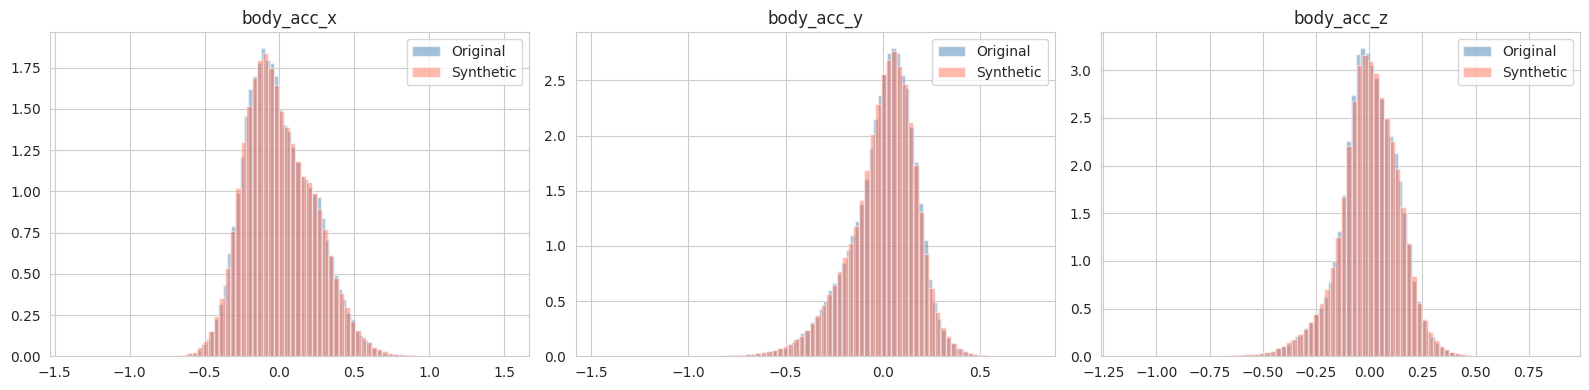

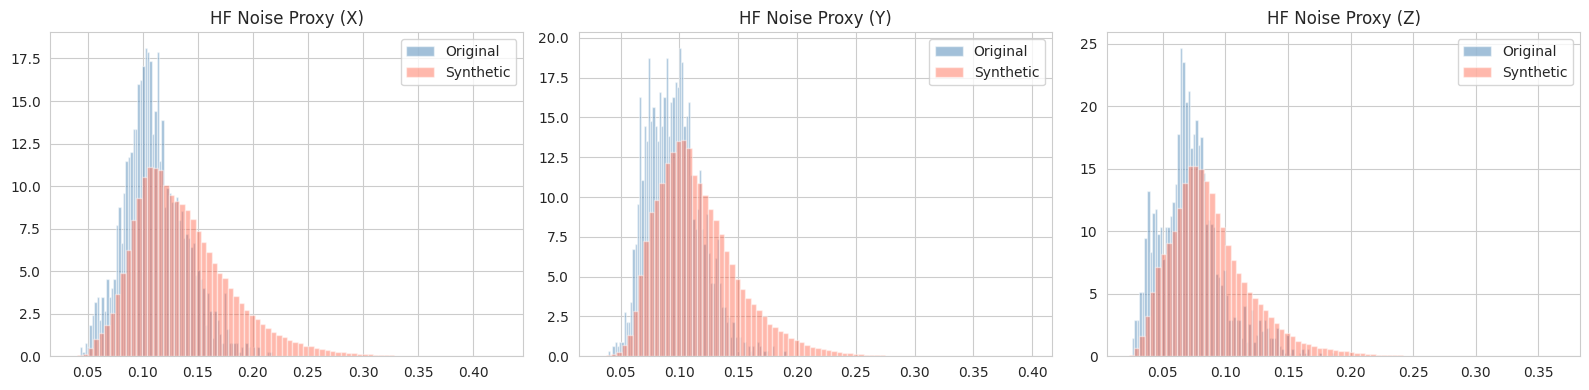

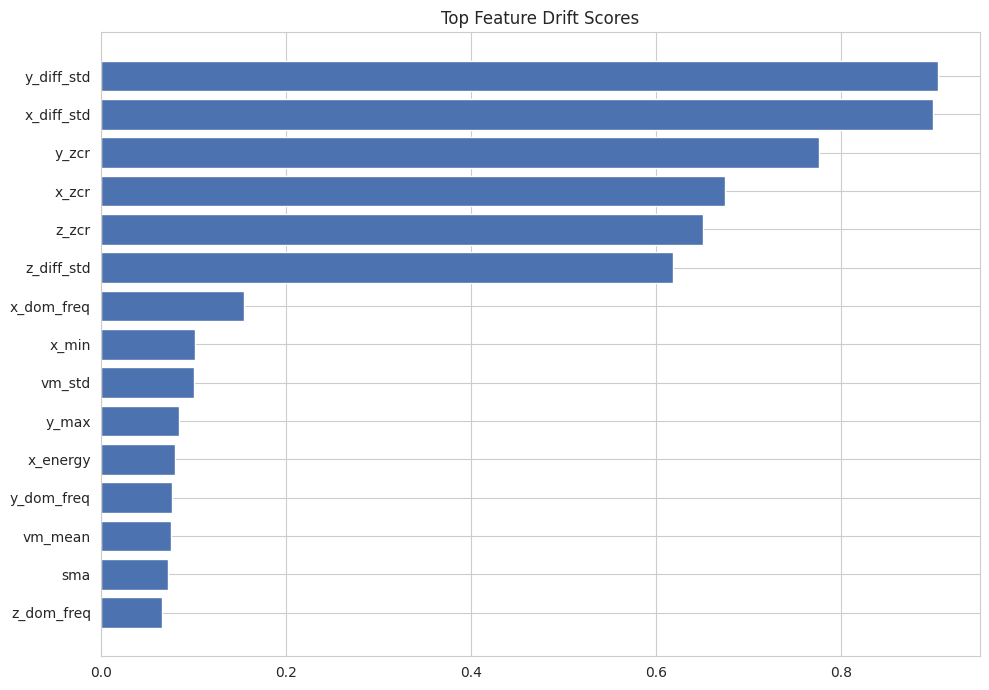

,0
original_samples,1722.000000
synthetic_samples,300000.000000
synthetic_subjects,30.000000
feature_count,27.000000
nan_count,0.000000
inf_count,0.000000
duplicate_vs_original,18120.000000
duplicate_within_synthetic,16877.000000
high_repeat_ratio_count,0.000000
amplitude_outlier_count,0.000000


In [10]:
cleaned_all = {
    'subjects': np.concatenate([
        np.load(CLEANED_PATH / 'train' / 'subjects.npy'),
        np.load(CLEANED_PATH / 'test' / 'subjects.npy')
    ]),
    'body_acc_x': np.concatenate([
        np.load(CLEANED_PATH / 'train' / 'body_acc_x.npy'),
        np.load(CLEANED_PATH / 'test' / 'body_acc_x.npy')
    ]),
    'body_acc_y': np.concatenate([
        np.load(CLEANED_PATH / 'train' / 'body_acc_y.npy'),
        np.load(CLEANED_PATH / 'test' / 'body_acc_y.npy')
    ]),
    'body_acc_z': np.concatenate([
        np.load(CLEANED_PATH / 'train' / 'body_acc_z.npy'),
        np.load(CLEANED_PATH / 'test' / 'body_acc_z.npy')
    ]),
}

report, drift_df = run_post_synthetic_analysis(
    cleaned_data=cleaned_all,
    synth_path=SYNTH_PATH,
    out_dir=POST_RESULTS_PATH,
    sr=50.0,
)

pd.DataFrame([report]).T


## Review Top Drift Features


In [11]:
drift_df[['feature', 'drift_score']].head(15)


,feature,drift_score
13,y_diff_std,0.905404
5,x_diff_std,0.899800
14,y_zcr,0.776981
6,x_zcr,0.675451
22,z_zcr,0.651397
21,z_diff_std,0.618938
7,x_dom_freq,0.155085
2,x_min,0.101708
25,vm_std,0.100746
11,y_max,0.084814


## Training Path

Use only this synthetic dataset path for training:
- `data/synthetic_walking_data`


In [12]:
TRAIN_SYNTH_PATH = SYNTH_PATH
print('Recommended synthetic path for training:', TRAIN_SYNTH_PATH)


Recommended synthetic path for training: /home/anshu/code_space/ai-employee-auth/data/synthetic_walking_data


## Confusion Matrix Metrics

This section demonstrates how to calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) from model predictions.


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_overall_confusion_metrics(y_true, y_pred):
    """
    Calculate OVERALL confusion matrix metrics (not per class).
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    
    Returns:
    --------
    dict: Dictionary containing overall TP, FP, TN, FN
    """
    # Get unique classes
    classes = np.unique(np.concatenate([y_true, y_pred]))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # Calculate OVERALL metrics
    # True Positives: sum of diagonal (correct predictions)
    tp_overall = np.trace(cm)
    
    # False Positives: sum of columns minus diagonal
    fp_overall = cm.sum(axis=0).sum() - tp_overall
    
    # False Negatives: sum of rows minus diagonal
    fn_overall = cm.sum(axis=1).sum() - tp_overall
    
    # True Negatives: total - TP - FP - FN
    total = cm.sum()
    tn_overall = total - tp_overall - fp_overall - fn_overall
    
    # Calculate metrics
    accuracy = tp_overall / total if total > 0 else 0
    precision = tp_overall / (tp_overall + fp_overall) if (tp_overall + fp_overall) > 0 else 0
    recall = tp_overall / (tp_overall + fn_overall) if (tp_overall + fn_overall) > 0 else 0
    f1_score = 2 * tp_overall / (2 * tp_overall + fp_overall + fn_overall) if (2 * tp_overall + fp_overall + fn_overall) > 0 else 0
    
    metrics = {
        'True Positives (TP)': int(tp_overall),
        'False Positives (FP)': int(fp_overall),
        'True Negatives (TN)': int(tn_overall),
        'False Negatives (FN)': int(fn_overall),
        'Total Samples': int(total),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }
    
    return metrics, cm, classes


def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    Plot confusion matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Subject {c}' for c in classes],
                yticklabels=[f'Subject {c}' for c in classes],
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_overall_metrics(metrics):
    """
    Plot overall confusion matrix metrics as bar chart.
    """
    # Extract the four main metrics
    categories = ['True Positives\n(TP)', 'False Positives\n(FP)', 
                  'True Negatives\n(TN)', 'False Negatives\n(FN)']
    values = [metrics['True Positives (TP)'], metrics['False Positives (FP)'],
              metrics['True Negatives (TN)'], metrics['False Negatives (FN)']]
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart for TP, FP, TN, FN
    bars = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Confusion Matrix Metrics', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Performance metrics
    perf_categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    perf_values = [metrics['Accuracy'], metrics['Precision'], 
                   metrics['Recall'], metrics['F1-Score']]
    perf_colors = ['#9b59b6', '#1abc9c', '#e67e22', '#34495e']
    
    bars2 = ax2.bar(perf_categories, perf_values, color=perf_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax2.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 1.1])
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# Example usage with dummy data (replace with actual model predictions)
print("\n" + "="*70)
print("=== OVERALL Confusion Matrix Metrics Example ===")
print("="*70 + "\n")

# Simulate predictions for 3 subjects
y_true_example = np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])
y_pred_example = np.array([1, 1, 1, 2, 3, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2])

metrics, cm, classes = calculate_overall_confusion_metrics(y_true_example, y_pred_example)

print("Confusion Matrix:")
print(cm)
print("\nRows = True Labels, Columns = Predicted Labels\n")

print("\n" + "="*70)
print("OVERALL METRICS (Across All Classes):")
print("="*70)
for metric_name, value in metrics.items():
    if isinstance(value, float):
        print(f"  {metric_name:25s}: {value:.4f}")
    else:
        print(f"  {metric_name:25s}: {value}")
print("="*70 + "\n")

# Plot confusion matrix
plot_confusion_matrix(cm, classes, 'Confusion Matrix - Gait Recognition')

# Plot overall metrics
plot_overall_metrics(metrics)

print("\nNote: Replace y_true_example and y_pred_example with actual")
print("model predictions to calculate real confusion matrix metrics.")
print("\nTP = Correctly predicted samples (diagonal sum)")
print("FP = Incorrectly predicted as positive (off-diagonal column sum)")
print("FN = Incorrectly predicted as negative (off-diagonal row sum)")
print("TN = Correctly predicted negatives (calculated from total)")
